In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib import font_manager
import matplotlib.patches as patches
import geopandas as gpd
from scipy.stats import rankdata

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

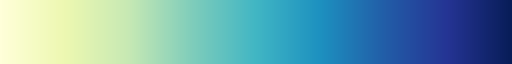

In [2]:
from palettable.cartocolors.sequential import Magenta_7, PurpOr_7
from palettable.cartocolors.sequential import Magenta_7, PurpOr_7, BluYl_7, DarkMint_7
from palettable.colorbrewer.sequential import YlGnBu_9, Blues_9
from palettable.cartocolors.diverging import Earth_7, TealRose_7, Temps_7
YlGnBu_9.mpl_colormap


#PurpOr_7.mpl_colormap

In [4]:
font_r = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Ubuntu-R.ttf')
font_m = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Ubuntu-M.ttf')
font_b = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Ubuntu-B.ttf')
#font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

# Clean

In [5]:
## Import, clean and join datasets
tabs = ["CW0302_1920", "CW0302_1819","CW0302_1718","CW0302_1617"]

column_names = ["Geography Code", "Area name", 
                "Any_Once per month", "Any_Once per week","Any_Three times per week",  "Any_Five times per week", 
                "Leisure_Once per month", "Leisure_Once per week","Leisure_Three times per week", "Leisure_Five times per week", 
                "Travel_Once per month", "Travel_Once per week","Travel_Three times per week", "Travel_Five times per week" ]

dfs = []

#loop through all tabs and join
for tab in tabs:
    #import
    df = pd.read_excel("cw0302.xlsx", sheet_name=tab, skiprows=7)
    df = df[~df[df.columns[1]].isnull()] #remove empty rows
    df = df.dropna(axis=1, how='all') #remove empty columns
    
    #rename columns
    df.columns = column_names
    
    #melt frame
    df = pd.melt(df, id_vars=["Geography Code", "Area name"], var_name="Type", value_name="Proportion")
    
    #clean up columns
    df["Frequency"] = [ sub[1] for sub in df["Type"].str.split("_")]
    df["Type"] = [ sub[0] for sub in df["Type"].str.split("_")]
    
    #add year column
    df["Survey_Period"] = "20" + tab.split("_")[1][:2] + "/" + tab.split("_")[1][2:]
    df["Year"] = "20" + tab.split("_")[1][2:] 

    dfs.append(df)

#join all tables
df = pd.concat(dfs, axis=0)

df.head()

,Geography Code,Area name,Type,Proportion,Frequency,Survey_Period,Year
0,E92000001,ENGLAND,Any,16.0952,Once per month,2019/20,2020
1,E12000001,North East,Any,12.5762,Once per month,2019/20,2020
2,E06000047,County Durham,Any,9.6027,Once per month,2019/20,2020
3,E06000005,Darlington,Any,13.0619,Once per month,2019/20,2020
4,E06000001,Hartlepool,Any,10.2977,Once per month,2019/20,2020


# London

In [6]:
pos_dict = {'E09000001': 29,  'E09000002': 32, 'E09000003': 12, 'E09000004': 40,  'E09000005': 19, 'E09000006': 46,
           'E09000007': 20, 'E09000008': 45,  'E09000009': 18,  'E09000010': 5,  'E09000011': 39,  'E09000012': 22,
           'E09000013': 26,  'E09000014': 13,  'E09000015': 11,  'E09000016': 24, 'E09000017': 17,  'E09000018': 25,
           'E09000019': 21,  'E09000020': 27,  'E09000021': 43, 'E09000022': 36,  'E09000023': 38,  'E09000024': 44,
           'E09000025': 31,  'E09000026': 23,  'E09000027': 34,  'E09000028': 37,  'E09000029': 52,  'E09000030': 30,
           'E09000031': 14,  'E09000032': 35,  'E09000033': 28}

display_dict = {'E09000007': 'CMD', 'E09000001': 'CTY', 'E09000012': 'HCK', 'E09000013': 'HMS', 'E09000014': 'HGY',
             'E09000019': 'ISL', 'E09000020': 'KNS', 'E09000022': 'LAM', 'E09000023': 'LSH', 'E09000025': 'NWM',
             'E09000028': 'SWR', 'E09000030': 'TOW', 'E09000032': 'WNS', 'E09000033': 'WST', 'E09000002': 'BAR',
             'E09000003': 'BRN', 'E09000004': 'BXL',  'E09000005': 'BRT',  'E09000006': 'BRM',  'E09000008': 'CRD',
             'E09000009': 'ELG',  'E09000010': 'ENF',  'E09000011': 'GRN',  'E09000015': 'HRW',  'E09000016': 'HVG',
             'E09000017': 'HDN',  'E09000018': 'HNS',  'E09000021': 'KNG',  'E09000024': 'MRT',  'E09000026': 'RDB',
             'E09000027': 'RCH',  'E09000029': 'STN',  'E09000031': 'WTH'}

In [7]:
table = df[df["Geography Code"].isin(pos_dict.keys())]
table.head()

,Geography Code,Area name,Type,Proportion,Frequency,Survey_Period,Year
218,E09000007,Camden,Any,22.2511,Once per month,2019/20,2020
219,E09000001,City of London,Any,20.4931,Once per month,2019/20,2020
220,E09000012,Hackney,Any,37.4197,Once per month,2019/20,2020
221,E09000013,Hammersmith and Fulham,Any,28.0155,Once per month,2019/20,2020
222,E09000014,Haringey,Any,18.6020,Once per month,2019/20,2020


## Bar chart single year - any cycling

In [36]:
filt = (table["Type"] == "Any") & (table["Year"]=="2020")
order = [ 'Once per month', 'Once per week',
       'Three times per week', 'Five times per week']
pivot = table[filt].pivot(index="Area name", columns="Frequency", values="Proportion")
pivot = pivot[order]
pivot.head()

Frequency,Once per month,Once per week,Three times per week,Five times per week
Area name,,,,
Barking and Dagenham,8.4830,6.2855,3.5504,1.7796
Barnet,10.2493,7.0642,4.1356,2.7616
Bexley,6.8080,4.7666,2.7775,2.0354
Brent,12.5926,9.9423,6.0644,2.2697
Bromley,14.8496,11.9086,4.9861,2.1294


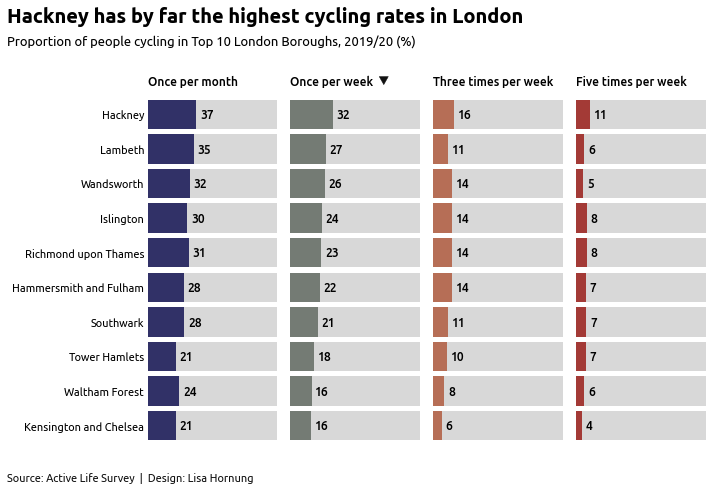

In [158]:
#TOP TEN BOROUGHS

data = pivot.sort_values(by="Once per week", ascending=True)[len(pivot)-10:]


colr = {"Once per month": "#313167", "Once per week": "#747b74", 
        "Three times per week":"#b66e56", "Five times per week": "#a33a36"}

###plot
fig, ax = plt.subplots(figsize=(10,7), sharey=True)


#adjust subplots
plt.subplots_adjust(wspace=0.1, hspace=0.0) 

#title

y = np.arange(len(data))

num = 0
for column in data.columns:
    num+=1
    plt.subplot(1,4,num)
    
    plt.barh(y, data[column],height=0.85, color=colr[column],zorder=3, linewidth=0)
    plt.barh(y, 100,height=0.85, color='#d8d8d8',zorder=2,linewidth=0 )
    
    #value labels
    for i in range(len(data[column])):
        plt.text(data[column][i]+3, y[i] , int(data[column][i]), size=12, va="center", 
                 weight='bold', fontproperties=font_m)
    
    #xaxis
    plt.gca().set_xlim(xmin=0, xmax=100)
    plt.gca().get_xaxis().set_ticks([]) #remove ticks
        
    #yaxis
    plt.gca().set_ylim(ymin=-1, ymax=len(data))
    plt.tick_params(axis='y', length = 0, color = "#444444")
    if num ==1:
        plt.gca().set_yticks(np.arange(0,len(data),1))
        plt.gca().set_yticklabels(data.index, fontsize=11, fontproperties=font_r)
    else:
        plt.yticks([0], [""])
    
    #remove frame
    for pos in ["top", "bottom", "left", "right"]:
        plt.gca().spines[pos].set_visible(False)
        
    #add arrow down
    if column == "Once per week":
        #define style
        style = "Simple, tail_width=0.6, head_width=9, head_length=8"
        kw = dict(arrowstyle=style, color="#111111")

        #define arrows
        a1 = patches.FancyArrowPatch((72, len(data)+0.1), (72, len(data)-0.2),clip_on=False,linewidth=0.5,
                            connectionstyle="arc3,rad=0", **kw)
        plt.gca().add_patch(a1)
        
    plt.title(column, size=12, x=0,y=0.97, ha='left', fontproperties=font_m)

#======
#Title, footer, notes
plt.figtext(-0.07,1.025, "Hackney has by far the highest cycling rates in London", fontproperties=font_b, va='top', fontsize=20)
plt.figtext(-0.07,0.97, "Proportion of people cycling in Top 10 London Boroughs, 2019/20 (%)", fontproperties=font_r, va='top', fontsize=13)
plt.figtext(-0.07,0.1, "Source: Active Life Survey  |  Design: Lisa Hornung", 
            fontproperties=font_r, color="#111111", fontsize=11, va="top")


#save output
plt.savefig("top-10-boroughs-by-cycling-rates_2019-20.png", bbox_inches='tight', transparent=True)

plt.show()

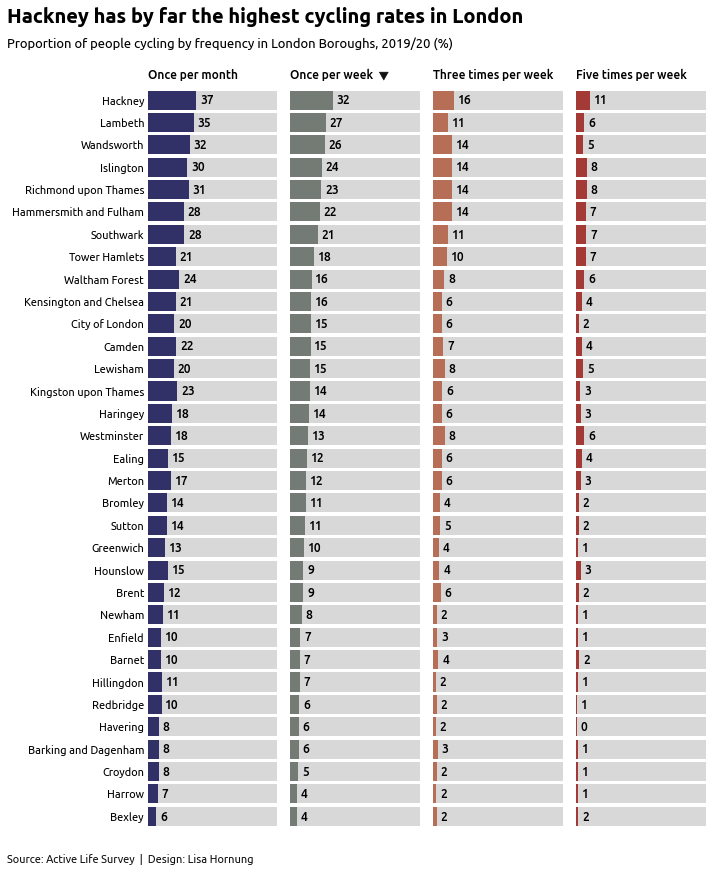

In [171]:
#ALL BOROUGHS

data = pivot.sort_values(by="Once per week", ascending=True)

colr = {"Once per month": "#313167", "Once per week": "#747b74", 
        "Three times per week":"#b66e56", "Five times per week": "#a33a36"}

###plot
fig, ax = plt.subplots(figsize=(10,14), sharey=True)


#adjust subplots
plt.subplots_adjust(wspace=0.1, hspace=0.0) 

#title

y = np.arange(len(data))

num = 0
for column in data.columns:
    num+=1
    plt.subplot(1,4,num)
    
    plt.barh(y, data[column],height=0.85, color=colr[column],zorder=3, linewidth=0)
    plt.barh(y, 100,height=0.85, color='#d8d8d8',zorder=2,linewidth=0 )
    
    #value labels
    for i in range(len(data[column])):
        plt.text(data[column][i]+3, y[i] , int(data[column][i]), size=12, va="center", 
                 weight='bold', fontproperties=font_m)
    
    #xaxis
    plt.gca().set_xlim(xmin=0, xmax=100)
    plt.gca().get_xaxis().set_ticks([]) #remove ticks
        
    #yaxis
    plt.gca().set_ylim(ymin=-1, ymax=len(data))
    plt.tick_params(axis='y', length = 0, color = "#444444")
    if num ==1:
        plt.gca().set_yticks(np.arange(0,len(data),1))
        plt.gca().set_yticklabels(data.index, fontsize=11, fontproperties=font_r)
    else:
        plt.yticks([0], [""])
    
    #remove frame
    for pos in ["top", "bottom", "left", "right"]:
        plt.gca().spines[pos].set_visible(False)
        
    #add arrow down
    if column == "Once per week":
        #define style
        style = "Simple, tail_width=0.6, head_width=9, head_length=8"
        kw = dict(arrowstyle=style, color="#111111")

        #define arrows
        a1 = patches.FancyArrowPatch((72, len(data)+0.1), (72, len(data)-0.2),clip_on=False,linewidth=0.5,
                            connectionstyle="arc3,rad=0", **kw)
        plt.gca().add_patch(a1)
        
    plt.title(column, size=12, x=0,y=0.99, ha='left', fontproperties=font_m)

#======
#Title, footer, notes
plt.figtext(-0.07,0.95, "Hackney has by far the highest cycling rates in London", 
            fontproperties=font_b, va='top', fontsize=20)
plt.figtext(-0.07,0.92, "Proportion of people cycling by frequency in London Boroughs, 2019/20 (%)", 
            fontproperties=font_r, va='top', fontsize=13)
plt.figtext(-0.07,0.11, "Source: Active Life Survey  |  Design: Lisa Hornung", 
            fontproperties=font_r, color="#111111", fontsize=11, va="top")


#save output
plt.savefig("London-boroughs-by-cycling-rates_2019-20.png", bbox_inches='tight', transparent=True)

plt.show()

## Ranking line chart

In [221]:
filt = (table["Frequency"] == "Once per week") & (table["Type"]=="Any")
pivot = table[filt][['Geography Code', 'Area name', 'Proportion', 'Survey_Period', 'Year']]
pivot["rank"] = pivot.groupby("Year")["Proportion"].transform(lambda x: rankdata(-x))
incl = 10
pivot = pivot[pivot["rank"] < incl+1]
pivot["y_pos"] = pivot["rank"].transform(lambda x: (x*-1)+(incl+1))
pivot["Area name"].unique()

array(['Hackney', 'Hammersmith and Fulham', 'Islington',
       'Kensington and Chelsea', 'Lambeth', 'Southwark', 'Tower Hamlets',
       'Wandsworth', 'Richmond upon Thames', 'Waltham Forest',
       'Westminster', 'Kingston upon Thames', 'Hounslow'], dtype=object)

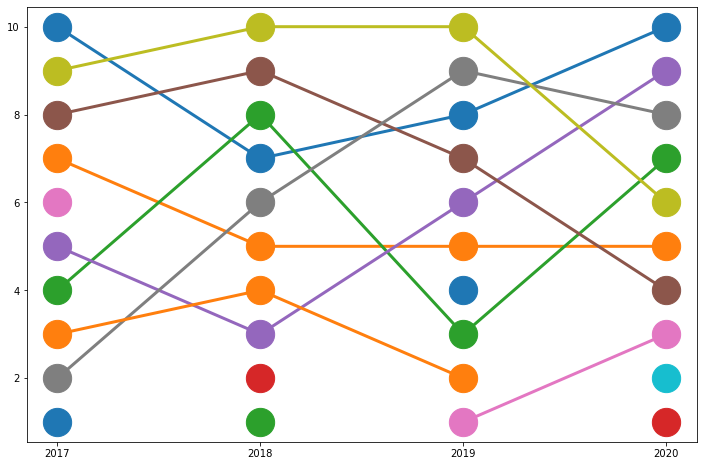

In [222]:
data = pivot

###plot
fig, ax = plt.subplots(figsize=(12,8), sharey=True)
fig.set_facecolor("white")

#plot
for borough in pivot["Area name"].unique():
    #create empty dataframe that has all years we want to plot
    d = pd.DataFrame({'Year':["2017", "2018", "2019", "2020"]})
    d = pd.merge(d, data[data["Area name"]==borough], left_on="Year", right_on="Year", how="left")
    
    #line chart and scatter for dots
    ax.plot(d["Year"], d["y_pos"], linewidth=3)
    ax.scatter(d["Year"],d["y_pos"], s=800)
    
plt.show()

## Dotplot - single year by reason

In [5]:
filt = (table["Frequency"] == "Once per week") & (table["Year"]=="2020")
pivot = table[filt].pivot(index="Area name", columns="Type", values="Proportion")
pivot.head()

Type,Any,Leisure,Travel
Area name,,,
Barking and Dagenham,6.2855,5.5837,2.3110
Barnet,7.0642,5.7698,4.3206
Bexley,4.7666,3.5155,2.5828
Brent,9.9423,5.8553,5.5475
Bromley,11.9086,7.9500,3.8314


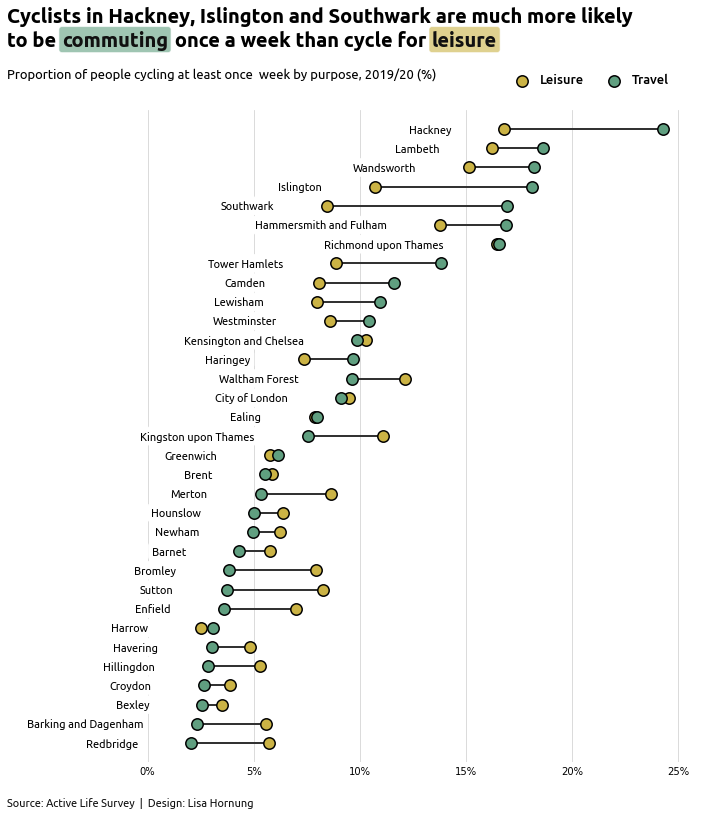

In [135]:
data = pivot.sort_values(by="Travel", ascending=True)
colr = {"Travel": "#609F80", "Leisure":"#CBB345"}

###plot
fig, ax = plt.subplots(figsize=(10,12), sharey=True)
fig.set_facecolor("white")


#dot plot
my_range = np.arange(len(data))
size = 130
plt.hlines(y=my_range, xmin=data['Leisure'], xmax=data['Travel'],linewidth=2, color='#333333', alpha=1, zorder=2)
plt.scatter(data['Leisure'], my_range, s=size, color=colr["Leisure"], linewidth=1.5, edgecolors='black', 
            alpha=1, label='Leisure', zorder=3)
plt.scatter(data['Travel'], my_range, s=size, color=colr["Travel"],linewidth=1.5, edgecolors='black', 
            alpha=1 , label='Travel', zorder=3)

#add borough names
for i in range(len(data)):
    plt.text(min(data[["Travel", "Leisure"]].iloc[i])-2.5, my_range[i], 
             data.index[i], ha='right', va='center', fontsize=11, fontproperties=font_r ,
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round'))
    #curved labels
    #plt.text(0.1*i + i**2/190, my_range[i], 
             #data.index[i], ha='right', va='center', fontsize=11, fontproperties=font_r,
            #bbox=dict(facecolor='white', edgecolor='white', boxstyle='round'))

#xaxis
plt.gca().set_xlim(xmin=0, xmax=max(data[["Travel", "Leisure"]].max())+2)
plt.gca().get_xaxis().set_ticks([0, 5,10,15,20,25]) #remove ticks
plt.grid(visible=True, axis='x', zorder=1, color = "#D3D3D3", label=12)
plt.gca().xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}%'))
        
#yaxis
plt.gca().set_ylim(ymin=-1, ymax=len(data))
plt.tick_params(axis='both', length = 0, color = "#444444")
plt.gca().set_yticks([])


#remove frame
for pos in ["top", "bottom", "left", "right"]:
    plt.gca().spines[pos].set_visible(False)
    
# ==========
#legend
L = ax.legend(ncol=2, frameon=False, loc='upper right',bbox_to_anchor=(0.95,1.07))
plt.setp(L.texts, fontproperties=font_m, fontsize=13)

#Title, footer, notes
plt.figtext(-0.07,1.0, "Cyclists in Hackney, Islington and Southwark are much more likely \nto be                         once a week than cycle for", 
            fontproperties=font_b, va='top', fontsize=20)
plt.figtext(0.006,0.973, "commuting", color='#111111', fontproperties=font_b, va='top', fontsize=20,
           bbox=dict(facecolor=colr["Travel"], edgecolor='white', boxstyle='round', pad=0.15, alpha=0.6))
plt.figtext(0.52,0.973, "leisure", fontproperties=font_b, va='top', fontsize=20, color='#111111',
           bbox=dict(facecolor=colr["Leisure"], edgecolor='white', boxstyle='round', pad=0.15, alpha=0.6))
plt.figtext(-0.07,0.93, "Proportion of people cycling at least once  week by purpose, 2019/20 (%)", 
            fontproperties=font_r, va='top', fontsize=13)
plt.figtext(-0.07,0.085, "Source: Active Life Survey  |  Design: Lisa Hornung",   
            fontproperties=font_r, color="#111111", fontsize=11, va="top")

#save output
plt.savefig("London-boroughs-cycling-rates-reason_2019-20.png", bbox_inches='tight', transparent=False)

plt.show()

## Cycling by reason - choropleth map

In [8]:
filt = (table["Frequency"] == "Once per week") & (table["Year"]=="2020")
pivot = table[filt].pivot(index="Area name", columns="Type", values="Proportion")
pivot["Point_diff"] = pivot["Travel"] - pivot["Leisure"]
pivot["Perc_diff"] = (pivot["Travel"] - pivot["Leisure"])/pivot["Leisure"]*100

#save csv
pivot.to_csv("cyclist-rates-by-purpose-for-map_2019-20.csv")

pivot.head()

Type,Any,Leisure,Travel,Point_diff,Perc_diff
Area name,,,,,
Barking and Dagenham,6.2855,5.5837,2.3110,-3.2727,-58.611673
Barnet,7.0642,5.7698,4.3206,-1.4492,-25.116988
Bexley,4.7666,3.5155,2.5828,-0.9327,-26.531077
Brent,9.9423,5.8553,5.5475,-0.3078,-5.256776
Bromley,11.9086,7.9500,3.8314,-4.1186,-51.806289


<AxesSubplot:>

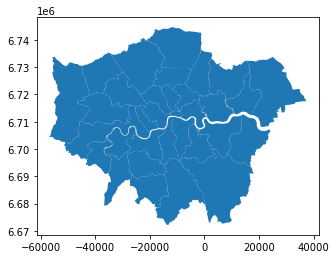

In [140]:
#load shapefile
fp = "London_Borough_Excluding_MHW.geojson"
map_df = gpd.GeoDataFrame.from_file(fp)

# join the geodataframe with the cleaned up csv dataframe
merged = map_df.set_index('NAME').join(pivot)
#print(merged.head())

map_df.plot()

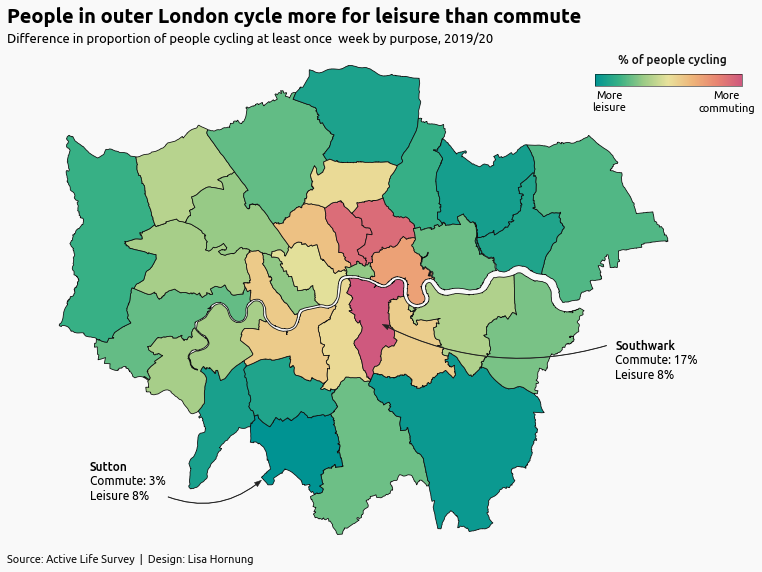

In [139]:
from palettable.cartocolors.diverging import Earth_7, TealRose_7, Temps_7
from palettable.colorbrewer.diverging import RdBu_10
from palettable.scientific.diverging import Broc_9, Cork_9, Vik_9

#input
variable = "Point_diff"
color = Temps_7

vmin, vmax = merged[variable].min(), merged[variable].max()
fig, ax = plt.subplots(figsize=(12,10))
fig.set_facecolor("#f9f9f9")

# create map
ax = merged.plot(column=variable, cmap=color.mpl_colormap, linewidth=0.8, ax=ax, edgecolor='#111111')
ax.axis('off')

#======
#colorbar
cbaxes = fig.add_axes([0.78, 0.8, 0.17, 0.017]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=color.mpl_colormap)                      
cb = plt.colorbar(cmappable, cax = cbaxes, anchor=(1,1.2), orientation='horizontal', drawedges=False,
            ticks=[0.1,  0.9])
cb.set_ticklabels(["More\nleisure","More\ncommuting" ], fontproperties=font_r, size=11, va='top')
cbaxes.tick_params(size=0)
cb.outline.set_linewidth(0.5)

#===========
#arrows and annotations
araxes = fig.add_axes([0.1, 0.2, 0.8, 0.6])
araxes.patch.set_alpha(0.01)
araxes.axis('off')

#define style
style = "Simple, tail_width=0.5, head_width=5, head_length=7"
kw = dict(arrowstyle=style, color="#222222")

#define arrows
a1 = patches.FancyArrowPatch((0.87, 0.4), (0.54, 0.45),linewidth=0.5,
                            connectionstyle="arc3,rad=-0.2", **kw, clip_on=False)
a2 = patches.FancyArrowPatch((0.23, 0.05), (0.37, 0.09),linewidth=0.5,
                            connectionstyle="arc3,rad=.3", **kw, clip_on=False)
#a3 = patches.FancyArrowPatch((44, -3.5), (45.4, -1.6),linewidth=0.5,
  #                          connectionstyle="arc3,rad=.5", **kw, clip_on=False)

#add arrows to plot
for a in [a1, a2]:
    araxes.add_patch(a)

#text
araxes.text(0.88, 0.4, "Southwark", fontproperties=font_m, size=12, va='center')
araxes.text(0.88, 0.35,"Commute: 17%\nLeisure 8%", fontproperties=font_r, size=12, va='center')

#text
araxes.text(0.12, 0.12, "Sutton", fontproperties=font_m, size=12, va='center')
araxes.text(0.12, 0.07,"Commute: 3%\nLeisure 8%", fontproperties=font_r, size=12, va='center')

#==========
#
plt.figtext(0.1,0.91, "People in outer London cycle more for leisure than commute", 
            fontproperties=font_b, va='top', fontsize=20)
plt.figtext(0.1,0.875, "Difference in proportion of people cycling at least once  week by purpose, 2019/20", 
            fontproperties=font_r, va='top', fontsize=13)
plt.figtext(0.1,0.15, "Source: Active Life Survey  |  Design: Lisa Hornung",   
            fontproperties=font_r, color="#111111", fontsize=11, va="top")
plt.figtext(0.87,0.845, "% of people cycling",   
            fontproperties=font_m, color="#111111", fontsize=12, va="top", ha='center')

#save
plt.savefig("London-boroughs-cycling-rates-reason-map_2019-20.png", bbox_inches='tight', transparent=False, pad_inches=0.15)

plt.show()